# Семинар "Свёрточные нейронные сети и trasfer learning"
## Андрей Бояров, ведущий программист-исследователь команды машинного зрения

# Cвёрточные нейронные сети

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL


def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    
def show_grayscale_image(image, figsize=(16, 9)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [4]:
import torch
import torchvision

In [5]:
layer = torch.nn.Conv2d(1, 1, kernel_size=3)

In [6]:
layer.weight

Parameter containing:
tensor([[[[ 0.1990, -0.2560, -0.2337],
          [ 0.0402, -0.0146,  0.1703],
          [-0.2592,  0.0522,  0.2192]]]], requires_grad=True)

In [7]:
# вес доступен через .weight.data
layer.weight.data = torch.ones_like(layer.weight.data) 
layer.weight.data /= torch.sum(layer.weight.data)

In [8]:
layer.weight.data

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])

In [9]:
layer.bias.data = torch.zeros_like(layer.bias.data)

In [10]:
layer.eval()

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [11]:
input_tensor = torch.arange(9).reshape(1, 1, 3, 3)

In [12]:
input_tensor.shape

torch.Size([1, 1, 3, 3])

In [13]:
input_tensor

tensor([[[[0, 1, 2],
          [3, 4, 5],
          [6, 7, 8]]]])

In [14]:
output_tensor = layer(input_tensor.float())

In [15]:
output_tensor

tensor([[[[4.]]]], grad_fn=<MkldnnConvolutionBackward>)

## Модификация весов свертки

In [16]:
path = './data/photos/lecun.jpeg'

In [17]:
# прочитайте изображение и переведите его в grayscale

img = cv2.imread(path, 0)

In [18]:
assert img.shape == (3960, 2640)

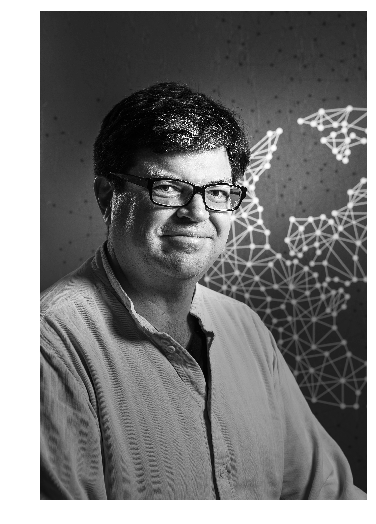

In [19]:
show_grayscale_image(img)

In [20]:
to_tensor = torchvision.transforms.ToTensor()

In [21]:
img_tensor = to_tensor(img)

In [22]:
img_tensor.shape

torch.Size([1, 3960, 2640])

In [23]:
# сделаейте так, чтобы assert в следующей строчке прошел

img_tensor = img_tensor.reshape((1, 1, 3960, 2640))

In [24]:
assert img_tensor.shape == torch.Size([1, 1, 3960, 2640])

## Создадим свертку, которая размоет изображение

In [25]:
kernel_size = 50
layer = torch.nn.Conv2d(1, 1, kernel_size=kernel_size)

In [26]:
# обновите веса так, чтобы получилась свертка, которая размывает изображение

layer.weight.data = torch.ones_like(layer.weight.data) 
layer.weight.data /= torch.sum(layer.weight.data)

In [27]:
layer.weight.data

tensor([[[[0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          ...,
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]]]])

In [28]:
layer.eval()

Conv2d(1, 1, kernel_size=(50, 50), stride=(1, 1))

In [29]:
output_tensor = layer(img_tensor)

In [30]:
output_tensor.shape

torch.Size([1, 1, 3911, 2591])

In [31]:
import torchvision.transforms as transforms

# функция, переводящее тензор в PIL-изображение
to_pil_image = transforms.ToPILImage()

In [32]:
output_img = to_pil_image(output_tensor.squeeze(0))

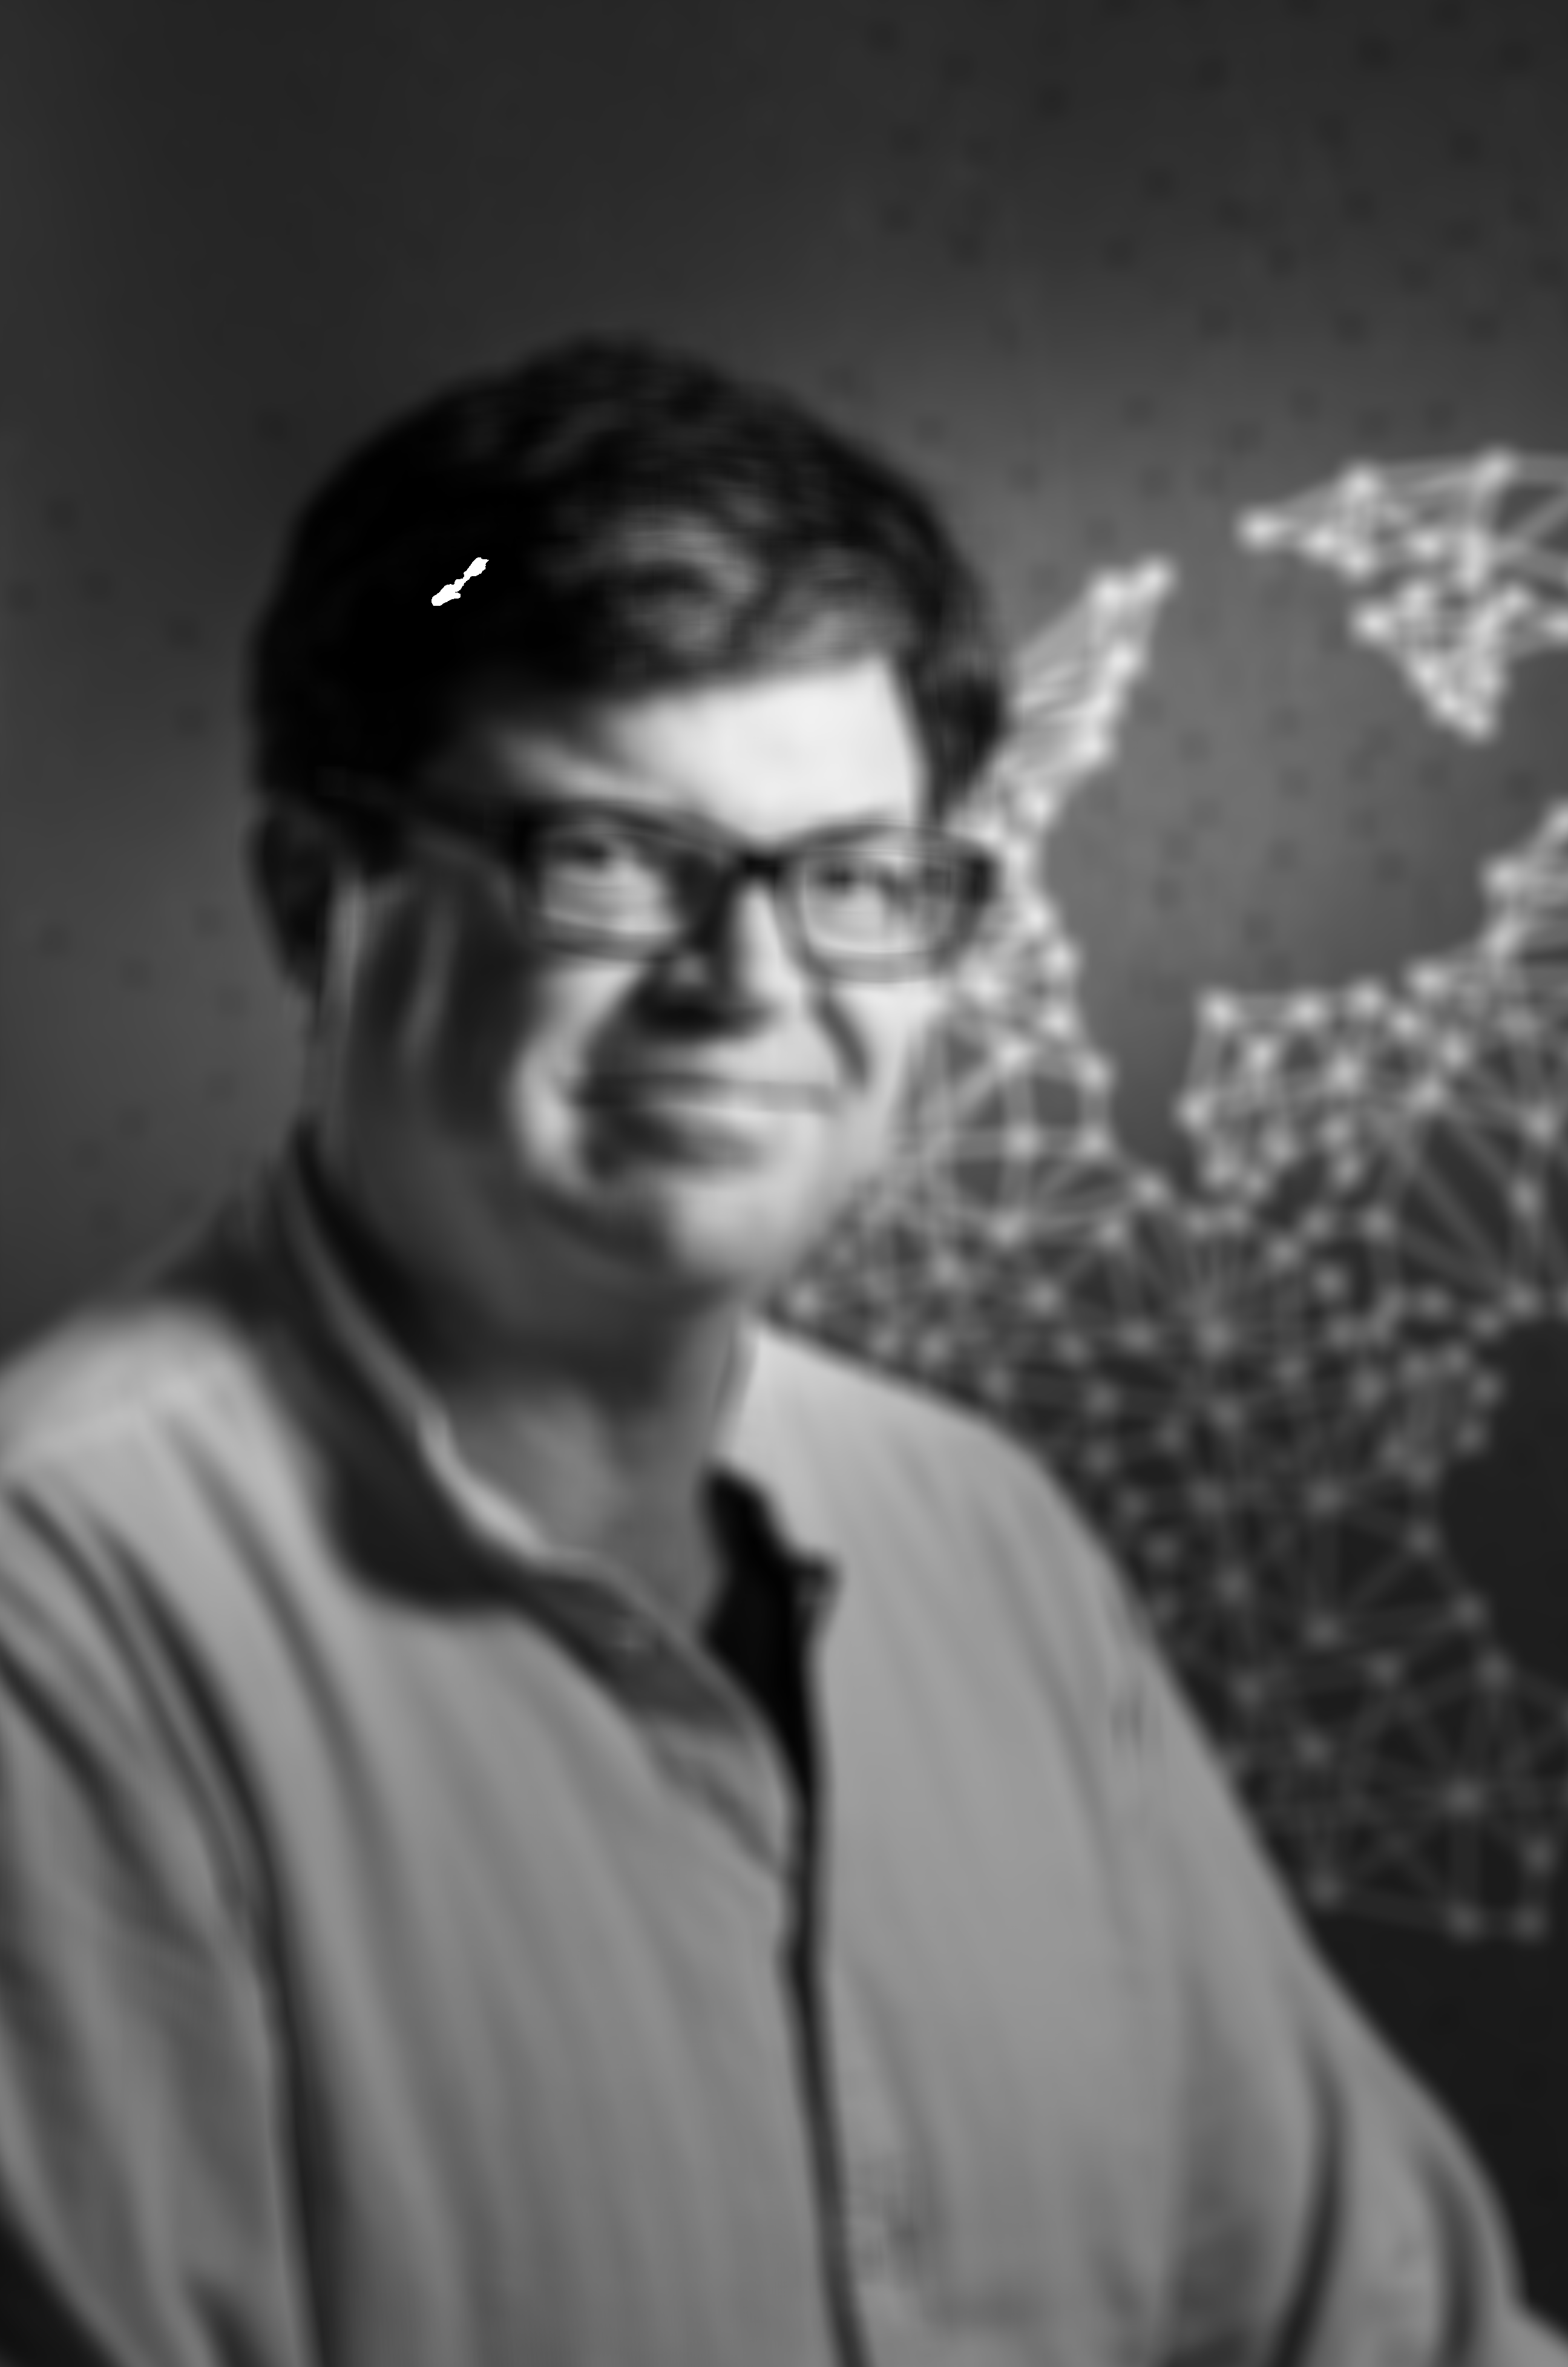

In [33]:
output_img

# Обучие моделей на изображениях

## Данные, преобразования

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [36]:
batch_size = 4

# dataset задаёт данные
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# dataloader подгружает их
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Отрисовка

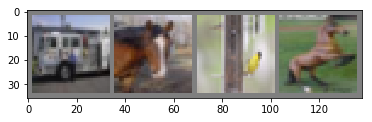

truck  horse  bird  horse


In [37]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    # убрать нормализацию
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# взять случайный батч изображений
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('  '.join('{}'.format(classes[labels[j]]) for j in range(4)))

## Рутина обучения модели

In [42]:
def train_model(net, criterion, optimizer, trainloader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            
            #дополните код
            
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('Epoch {0}/{1}, iteration {2}, loss: {3:.3f}'.format(epoch + 1, num_epochs, i + 1, 
                                                                          running_loss / 2000))
                running_loss = 0.0
        print()

    print('Finished Training')
    
    return net

## Точность модели на тестовом сете

In [43]:
def all_accuracy(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            # дополните код
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(
        100 * correct / total))

In [44]:
def class_accuracy(net, testloader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of {} : {} %'.format(
            classes[i], 100 * class_correct[i] / class_total[i]))

## Полносвязная сеть для классификации

In [38]:
import torch.nn as nn
import torch.nn.functional as F

# созлайте сеть, состоящую из 3-х полносвязных слоёв (input_size -> 128, 128 -> 32, 32 -> output_size) 
# и испрользовала в качестве активции ReLU

class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        # tip: используйте функцию view для преобразования входа
        x = x.view(-1, 3 * 32 * 32)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
net = FeedForwardNet()

In [39]:
import torch.optim as optim

# дополните код

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [45]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=5)

Epoch 1/5, iteration 2000, loss: 1.938
Epoch 1/5, iteration 4000, loss: 1.749
Epoch 1/5, iteration 6000, loss: 1.669
Epoch 1/5, iteration 8000, loss: 1.629
Epoch 1/5, iteration 10000, loss: 1.586
Epoch 1/5, iteration 12000, loss: 1.564

Epoch 2/5, iteration 2000, loss: 1.506
Epoch 2/5, iteration 4000, loss: 1.478
Epoch 2/5, iteration 6000, loss: 1.499
Epoch 2/5, iteration 8000, loss: 1.501
Epoch 2/5, iteration 10000, loss: 1.456
Epoch 2/5, iteration 12000, loss: 1.461

Epoch 3/5, iteration 2000, loss: 1.401
Epoch 3/5, iteration 4000, loss: 1.392
Epoch 3/5, iteration 6000, loss: 1.392
Epoch 3/5, iteration 8000, loss: 1.393
Epoch 3/5, iteration 10000, loss: 1.408
Epoch 3/5, iteration 12000, loss: 1.404

Epoch 4/5, iteration 2000, loss: 1.333
Epoch 4/5, iteration 4000, loss: 1.317
Epoch 4/5, iteration 6000, loss: 1.346
Epoch 4/5, iteration 8000, loss: 1.348
Epoch 4/5, iteration 10000, loss: 1.345
Epoch 4/5, iteration 12000, loss: 1.347

Epoch 5/5, iteration 2000, loss: 1.251
Epoch 5/5, it

In [46]:
all_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 49.36 %


In [47]:
class_accuracy(net, testloader)

Accuracy of plane : 68.9 %
Accuracy of car : 55.1 %
Accuracy of bird : 34.7 %
Accuracy of cat : 31.2 %
Accuracy of deer : 52.2 %
Accuracy of dog : 33.5 %
Accuracy of frog : 56.4 %
Accuracy of horse : 48.8 %
Accuracy of ship : 63.4 %
Accuracy of truck : 49.4 %


## Свёрточная сеть для классификации

In [48]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [50]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=5)

Epoch 1/5, iteration 2000, loss: 2.204
Epoch 1/5, iteration 4000, loss: 1.903
Epoch 1/5, iteration 6000, loss: 1.697
Epoch 1/5, iteration 8000, loss: 1.596
Epoch 1/5, iteration 10000, loss: 1.499
Epoch 1/5, iteration 12000, loss: 1.473

Epoch 2/5, iteration 2000, loss: 1.398
Epoch 2/5, iteration 4000, loss: 1.374
Epoch 2/5, iteration 6000, loss: 1.344
Epoch 2/5, iteration 8000, loss: 1.330
Epoch 2/5, iteration 10000, loss: 1.311
Epoch 2/5, iteration 12000, loss: 1.292

Epoch 3/5, iteration 2000, loss: 1.212
Epoch 3/5, iteration 4000, loss: 1.218
Epoch 3/5, iteration 6000, loss: 1.213
Epoch 3/5, iteration 8000, loss: 1.190
Epoch 3/5, iteration 10000, loss: 1.178
Epoch 3/5, iteration 12000, loss: 1.191

Epoch 4/5, iteration 2000, loss: 1.087
Epoch 4/5, iteration 4000, loss: 1.123
Epoch 4/5, iteration 6000, loss: 1.134
Epoch 4/5, iteration 8000, loss: 1.131
Epoch 4/5, iteration 10000, loss: 1.080
Epoch 4/5, iteration 12000, loss: 1.094

Epoch 5/5, iteration 2000, loss: 1.027
Epoch 5/5, it

In [ ]:
# сохраним сеть
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('{}'.format(classes[labels[j]]) for j in range(batch_size)))

In [ ]:
# загрузим сеть
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('{}'.format(classes[predicted[j]]) for j in range(4)))

In [ ]:
all_accuracy(net, testloader)

In [ ]:
class_accuracy(net, testloader)

### Cuda

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)

# Transfer learning 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## Данные, предобработка

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Рутина обучения

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

## Визуализация работы модели

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Предобученный на ImageNet ResNet-18

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

## Дообучаем все слои

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

In [ ]:
visualize_model(model_ft)

## Теперь дообучаем только последний слой

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    # градиенты теперь не будут здесь протекать
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
# по умолчанию requires_grad = True
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

In [ ]:
visualize_model(model_conv)

# Оцека эстетической красоты фотографии

Необходимо для сортировки пользовательских фотографий, выбора лучшего кадра для превью и т.д.

A Large-Scale Database for Aesthetic Visual Analysis (AVA): 255 000 изображений, для каждого фото около 200 людей выставили оценку от 1 (плохо) до 10 (хорошо)

![](./data/photos/ava_examples.png)

![aaa](./data/photos/ava_mean_std.png)

1. ResNet-18, предобученная на ImageNet для извлечения признаков.
2. Добавляем несколько полносвязных слоёв, которые обучаются на AVA.
3. Используем Earth Mover’s Distance

![](./data/photos/emd.png)